# Functional Programming: Maximizing the Efficacy of Python Functions 


In this workbook, we'll take our knowledge of python functions to the next level. In particular, we'll talk about 

- Type hinting function definitions and properly documenting
- `*args` and `**kwargs` (along with packing and unpacking function arguments)
- Unit testing 

## Documentation and Type Hinting

A typical Python function we are used to writing may look something like this:

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

In [17]:
def centroid_2D(pixels,x_loc,y_loc,x_win,y_win):
    x_window = np.arange(x_loc-int(np.floor(x_win/2)),x_loc+int(np.floor(x_win/2))) 
    y_window = np.arange(y_loc-int(np.floor(y_win/2)),y_loc+int(np.floor(y_win/2)))
    x,y = np.meshgrid(x_window,y_window)
    crop=pixels[y_loc-int(np.floor(y_win/2)):y_loc+int(np.floor(y_win/2)),x_loc-int(np.floor(x_win/2)):x_loc+int(np.floor(x_win/2))]
    x_cen = np.sum(crop*x)/np.sum(crop) 
    y_cen = np.sum(crop*y)/np.sum(crop) 
    return x_cen,y_cen 

We can see what our function does by creating some fake data:

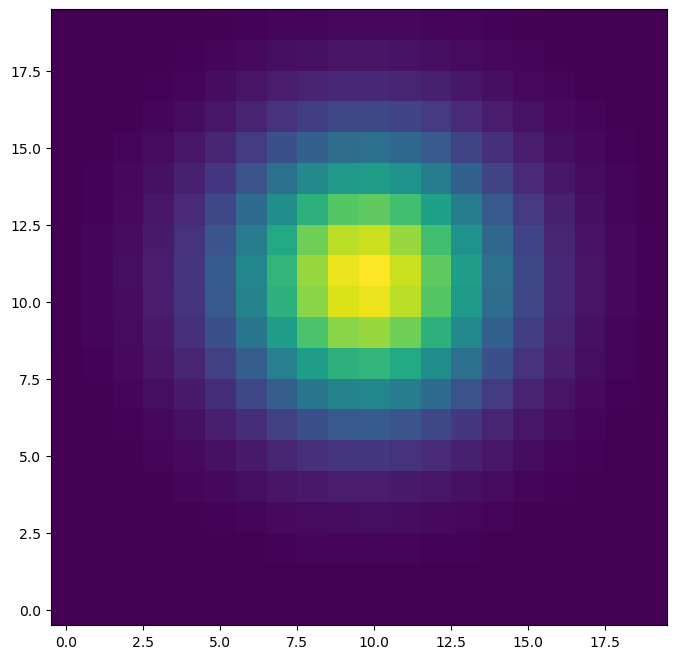

In [ ]:
from astropy.modeling.functional_models import Gaussian2D
def eval_gauss(x_arr,y_arr,sigma_x,sigma_y,mu_x,mu_y):
    
    g = Gaussian2D.evaluate(x=x_arr,y=y_arr,amplitude=1,theta=0,x_mean=mu_x,
                   y_mean=mu_y,
                   x_stddev=sigma_x,
                   y_stddev=sigma_y)
    g/=np.sum(g)
    return g
xx, yy = np.meshgrid(np.arange(20),
                     np.arange(20))
model = eval_gauss(x_arr=xx,y_arr=yy,sigma_x=3,sigma_y=3,mu_x=9.75,mu_y=10.75)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(model,origin='lower')

Above I have created a 2D gaussian, which might be a reasonable approximation of some star or source we wish to centroid. Let's run our function on it:

In [22]:
x_cen, y_cen = centroid_2D(model,x_loc=10,y_loc=11,x_win=10,y_win=10)
print(x_cen,y_cen)

9.658314583634262 10.658314583634263


Plotting over our data (and comparing the values to what we entered in), this seems to have done a good job locating the center!


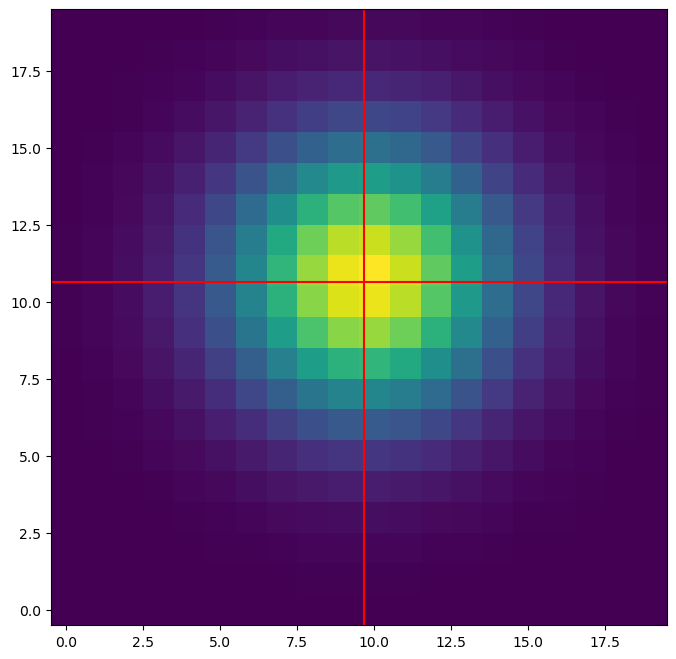

In [23]:
fig,ax=plt.subplots(figsize=(8,8)) 
ax.imshow(model,origin='lower')
ax.axhline(y_cen,color='r')
ax.axvline(x_cen,color='r')

Okay, all of that was an aside, because the focus here is on type hinting. 

Looking at our function again, it might not be clear to us exactly what the functional arguments are asking for, or how they are being used. We can help add clarity here via some docstrings and type hints:

In [25]:
def centroid_2D(pixels:np.array,
                x_loc:int,
                y_loc:int,
                x_win:int = None,
                y_win:int = None):
    """
    Function to calculate the 2D centroid of a pixel distribution. 
    
    Parameters
    ----------
    pixels: np.array_like
        the image to centroid, containing some peaked source.
    x_loc: int
        Approximate x-location of the peak (i.e., a peak pixel). 
    y_loc: int
        Approximate y-location of the peak. 
    x_win: int, optional
        Window size to use when centroiding x. If None, will use the full input image width, default None.
    y_win: int, optional
        Window size to use when centroiding y. If None, will use the full input image height, default None.
    
    Returns
    -------
    x_cen,y_cen -> np.float, np.float
        the x and y centroid
    """
    if x_win is None:
        x_win = pixels.shape[1]
    if y_win is None:
        y_win = pixels.shape[0]
    x_window = np.arange(x_loc-int(np.floor(x_win/2)),x_loc+int(np.floor(x_win/2))) 
    y_window = np.arange(y_loc-int(np.floor(y_win/2)),y_loc+int(np.floor(y_win/2)))
    x,y = np.meshgrid(x_window,y_window)
    crop=pixels[y_loc-int(np.floor(y_win/2)):y_loc+int(np.floor(y_win/2)),x_loc-int(np.floor(x_win/2)):x_loc+int(np.floor(x_win/2))]
    x_cen = np.sum(crop*x)/np.sum(crop) 
    y_cen = np.sum(crop*y)/np.sum(crop) 
    return x_cen,y_cen 

Several things about our function have improved in this iteration. First, we have added *type hinting* to the function arguments. By adding colons and the expexted data type of that variable, we clue the user (including ourselves, later) in to what types of input this function needs. For example, it is useful to know that `x_loc` and `y_loc` must be integer inputs.

:::{admonition} Quick Exercise
:class: tip
Why will the above function fail if a non integer is input for `x_loc`?
::: 

Additionally, we have utilized the use of *optional* keyword arguments, which both have type hints *and* default values. If you look inside the function, the first few lines now handle what happens when these values are `None`. 
And finally, we have added properly formatted documentation, which defines the parameters of the function, descriptions of them, and describes what the function outputs. This lets us now run, e.g., the `help()` function on it:

In [26]:
help(centroid_2D)

Help on function centroid_2D in module __main__:

centroid_2D(pixels: <built-in function array>, x_loc: int, y_loc: int, x_win: int = None, y_win: int = None)
    Function to calculate the 2D centroid of a pixel distribution. 
    
    Parameters
    ----------
    pixels: np.array_like
        the image to centroid, containing some peaked source.
    x_loc: int
        Approximate x-location of the peak (i.e., a peak pixel). 
    y_loc: int
        Approximate y-location of the peak. 
    x_win: int, optional
        Window size to use when centroiding x. If None, will use the full input image width, default None.
    y_win: int, optional
        Window size to use when centroiding y. If None, will use the full input image height, default None.
    
    Returns
    -------
    x_cen,y_cen -> np.float, np.float
        the x and y centroid



Additionally, if you are using a fully featured editor like `VSCode`, when you type out this function, or hover over its name, the type hints for the inputs will pop up on screen, making it easy to ensure you are using a function as intended. 

### Multiple Allowed Types

What if our function can handle both, e.g., a python list *or* a `numpy` array? For that, we can import the `typing` library and utilize the `Union` operator:

In [31]:
from typing import Union 

def my_func(input_var:Union[list,np.array]):
    pass

The `Union` operator, attached to the allowed types, says "the input must be a list OR a numpy array". 

:::{warning}
Note that Python, by default, does not check or confirm that inputs to a function match the types listed in the type hinting. However, there are external packages, like `mypy`, that can carry out such an assertion.
:::

If we have a common combination of inputs allowed, we can also define a custom type for them:

In [34]:
import pandas as pd 
import astropy
import numpy

keyed_data = Union[pd.DataFrame,dict,astropy.table.Table,numpy.recarray] 

def my_func(input_var: keyed_data):
    pass

In this case, we have defined `keyed_data` as the union of these several different data storage types which allow access-by-attribute (dict-like access). We then use this in our function definition.

